# Data Preprocessing


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
train_df = pd.read_csv('../datasets/train.csv')
test_df = pd.read_csv('../datasets/test.csv')
print(f' Train DS: {train_df.shape}, Test DS: {test_df.shape}')

 Train DS: (891, 12), Test DS: (418, 11)


Data Pipeline:

1) Feature Engineering
- 1a) Drop Var Cabin, create Family_Size and Titles Features, Impute Embark missing values with 'S' as highest frequency
- 1b) Convert categorical vars in dummie vars
- 1c) Fit Kmeans model with train data to predict age group

2) Imputations
- 2a) impute age in train and test based on Kmeans groups

3) Feature Selection

4) Resampling Train Dataset
5) Feature Scaling

6) Split and Export Datasets Xtrain, ytrain, Xtest

## Train and Test Datasets Preprocessing

### Step 1: Feature Engineering

#### 1a) Drop Var Cabin, create Family_Size and Titles Features, and Fill NA Values for Embark feature


In [32]:
# Family Size Feature
train_df['Family_Size'] = 0
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch']
test_df['Family_Size'] = 0
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch']

# Drop variables no used for the modeling
print('Before Drop: ', train_df.shape, test_df.shape)
train_df.drop(['Cabin','SibSp','Parch','Ticket'], axis=1, inplace=True)
test_df.drop(['Cabin','SibSp','Parch','Ticket'], axis=1, inplace=True)
print('After Drop: ', train_df.shape, test_df.shape)

# Fill NA values in Embark column with value 'S'in Train DS, Fill NA Fare with mean in Test DS
train_df['Embarked'].fillna('S', inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

# Verify train_df has not more NA values in Embark var
train_df[train_df['Embarked'].isnull()]

# Test Dataset doesn't show missing values for Embark var

Before Drop:  (891, 13) (418, 12)
After Drop:  (891, 9) (418, 8)


,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family_Size


In [33]:
# Receive Pandas Serie
def convert_titles(df):
    df.loc[ df['Titles'] == "Mlle", ['Titles'] ] = 'Miss'           # Mlle is equivalent to Miss (2 Records)
    df.loc[ df['Titles'] == "the countess", ['Titles'] ] = 'Miss'   # The Countess will be renamed to "Miss" (1 Record)
    df.loc[ df['Titles'] == "the Countess", ['Titles'] ] = 'Miss'   # The Countess will be renamed to "Miss" (1 Record)
    df.loc[ df['Titles'] == "Don", ['Titles'] ] = 'Mr'              # Don to be renamed to "Mr" (1 Record)
    df.loc[ df['Titles'] == "Capt", ['Titles'] ] = 'Mr'             # Capt to be renamed to "Mr" (1 Record)
    df.loc[ df['Titles'] == "Rev", ['Titles'] ] = 'Mr'              # Rev to be renamed to "Mr" (6 Records)
    df.loc[ df['Titles'] == "Dr", ['Titles'] ] = 'Mr'               # Dr to be renamed to "Mr" if Sex = Male else "Mrs' (7 Records)
    df.loc[ df['Titles'] == "Ms", ['Titles'] ] = 'Mrs'              # Ms to be renamed to "Mrs" (1 Record)
    df.loc[ df['Titles'] == "Major", ['Titles'] ] = 'Mr'            # Major to be renamed to Mr (2 Records)
    df.loc[ df['Titles'] == "Lady", ['Titles'] ] = 'Mrs'            # Lady to be renamed to Mrs (1 Record)
    df.loc[ df['Titles'] == "Sir", ['Titles'] ] = 'Mr'              # Sir to be renamed to Mr (1 Record)
    df.loc[ df['Titles'] == "Col", ['Titles'] ] = 'Mr'              # Col to be renamed to Mr (2 Records)
    df.loc[ df['Titles'] == "Jonkheer", ['Titles'] ] = 'Mr'         # Jonkheer to be renamed to Mr (1 Record)
    df.loc[ df['Titles'] == "Mme", ['Titles'] ] = 'Mrs'             # Mme to be renamed to Mrs (1 Record)
    df.loc[ df['Titles'] == "Dona", ['Titles'] ] = 'Mrs'

    return df

In [34]:
# Create Titles new feature based on prefix name variable (Mr, Miss, Mrs, etc)

train_df['Titles'] = train_df['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()
test_df['Titles'] = test_df['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()

# Call function for both Datasets
train_df = convert_titles(train_df)
print('train_df Classes:', train_df['Titles'].unique())

test_df = convert_titles(test_df)
print('test_df Classes:',test_df['Titles'].unique())

train_df Classes: ['Mr' 'Mrs' 'Miss' 'Master']
test_df Classes: ['Mr' 'Mrs' 'Miss' 'Master']


In [35]:
print('train_df info:\n', train_df.nunique())
print('\ntest_df info:\n', test_df.nunique())

train_df info:
 PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
Fare           248
Embarked         3
Family_Size      9
Titles           4
dtype: int64

test_df info:
 PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
Fare           170
Embarked         3
Family_Size      9
Titles           4
dtype: int64


#### 1b) Convert Categorical Features to Dummies 
Using Pandas Dumies
###
Pclass: 3 Classes -> 2 dummy vars<br>
Sex: 2 Class -> 1 dummy var <br>
Embarked: 3 Classes -> 2 dummy vars <br>
Titles: 4 Classes -> 3 dummy vars <br>
Family Size: 9 Classes -> 8 dummy vars <br>
###

In [36]:
train_df = pd.get_dummies(data=train_df, columns=['Pclass','Sex','Embarked','Titles','Family_Size'], drop_first=True )
test_df = pd.get_dummies(data=test_df, columns=['Pclass','Sex','Embarked','Titles','Family_Size'], drop_first=True )


print('Train Cols: ', train_df.columns, train_df.shape)
print('Test Cols: ', test_df.columns, test_df.shape)

Train Cols:  Index(['PassengerId', 'Survived', 'Name', 'Age', 'Fare', 'Pclass_2',
       'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Titles_Miss',
       'Titles_Mr', 'Titles_Mrs', 'Family_Size_1', 'Family_Size_2',
       'Family_Size_3', 'Family_Size_4', 'Family_Size_5', 'Family_Size_6',
       'Family_Size_7', 'Family_Size_10'],
      dtype='object') (891, 21)
Test Cols:  Index(['PassengerId', 'Name', 'Age', 'Fare', 'Pclass_2', 'Pclass_3',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Titles_Miss', 'Titles_Mr',
       'Titles_Mrs', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3',
       'Family_Size_4', 'Family_Size_5', 'Family_Size_6', 'Family_Size_7',
       'Family_Size_10'],
      dtype='object') (418, 20)


#### 1c) Fit Kmeans model with train data to predict age group

In [37]:
# Create a copy of train_df dataset to preprocess only features used to model kmeans
col_selection = ['Fare', 'Pclass_2','Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
                 'Titles_Miss','Titles_Mr', 'Titles_Mrs',
                 'Family_Size_1', 'Family_Size_2','Family_Size_3', 'Family_Size_4', 'Family_Size_5', 'Family_Size_6',
                 'Family_Size_7', 'Family_Size_10']
                
X_kmeans = train_df[col_selection].copy()
X_kmeans.head()

,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,Family_Size_6,Family_Size_7,Family_Size_10
0,7.2500,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0
1,71.2833,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,7.9250,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,53.1000,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0
4,8.0500,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0


## Using One Hot Encoder

In [38]:
# # Use OneHot Encoder for Columns Titles, Embarked, Sex
# from sklearn.preprocessing import OneHotEncoder

# col_selection = ['Sex','Embarked','Titles','Family_Size']
# enc = OneHotEncoder(handle_unknown='ignore',  sparse_output=True)
# one_hot_encoded = enc.fit_transform(X_kmeans[col_selection]).toarray()
# tmp = pd.DataFrame(one_hot_encoded, columns=enc.get_feature_names_out(col_selection))
# tmp.drop(['Sex_male'], axis=1, inplace=True)
# tmp.rename(columns={"Sex_female":"Sex"}, inplace=True)
# print(tmp.shape)
# tmp.head(10)

### Elbow Method to find # of Clusters

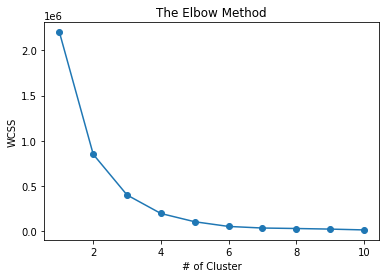

In [39]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init='auto' )
    kmeans.fit(X_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker ='o' )
plt.title('The Elbow Method')
plt.xlabel('# of Cluster')
plt.ylabel('WCSS')
plt.show()

### Train Kmeans model

In [40]:
# Fit the model using 4 groups
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42, n_init='auto' )
kmeans.fit(X_kmeans)

# Join Groups to original Train Dataset using indexes
train_df = train_df.join(pd.DataFrame(data= kmeans.labels_, columns=['Group']))
print(train_df.columns, train_df.shape)

Index(['PassengerId', 'Survived', 'Name', 'Age', 'Fare', 'Pclass_2',
       'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Titles_Miss',
       'Titles_Mr', 'Titles_Mrs', 'Family_Size_1', 'Family_Size_2',
       'Family_Size_3', 'Family_Size_4', 'Family_Size_5', 'Family_Size_6',
       'Family_Size_7', 'Family_Size_10', 'Group'],
      dtype='object') (891, 22)


In [41]:
# Join Groups to original Test Dataset using indexes after Predicting the Group for Test DS
group_test = kmeans.predict(test_df[col_selection])
test_df = test_df.join(pd.DataFrame(data= group_test, columns=['Group']))
print(test_df.columns, test_df.shape)

Index(['PassengerId', 'Name', 'Age', 'Fare', 'Pclass_2', 'Pclass_3',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Titles_Miss', 'Titles_Mr',
       'Titles_Mrs', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3',
       'Family_Size_4', 'Family_Size_5', 'Family_Size_6', 'Family_Size_7',
       'Family_Size_10', 'Group'],
      dtype='object') (418, 21)


### Step 2: Imputation

In [42]:
# # Clean X for Classifier model
# col_selection = ['Pclass','Fare_tmp','Name','SibSp','Parch','Ticket','ageCategory','Family_Size','Alone','Sex','fareCategory','Embarked']
# X.drop(col_selection, axis=1, inplace=True)
# X.columns

In [43]:
# Show number of Age missing values by Group
print('Age Missing Values by Group in Train Dataset')
print(train_df[train_df['Age'].isnull()].groupby('Group')['Group'].agg('count'))

print('Age Missing Values by Group in Test Dataset')
print(test_df[test_df['Age'].isnull()].groupby('Group')['Group'].agg('count'))

Age Missing Values by Group in Train Dataset
Group
0    154
1      3
2     20
Name: Group, dtype: int64
Age Missing Values by Group in Test Dataset
Group
0    81
2     5
Name: Group, dtype: int64


In [44]:
# Calculate mean and median for Age by Group
print('Measures by Group in Train Dataset')
print(train_df[train_df['Age'].notnull()].groupby('Group')['Age'].agg(['mean','median']))

# print('Measures by Group in Test Dataset')
print(test_df[test_df['Age'].notnull()].groupby('Group')['Age'].agg(['mean','median']))


Measures by Group in Train Dataset
            mean  median
Group                   
0      28.507509    27.5
1      30.996800    27.0
2      34.908333    34.0
3      35.333333    35.0
            mean  median
Group                   
0      27.609127    26.0
1      42.613636    42.0
2      36.798246    37.0
3      58.000000    58.0


In [45]:
# Most of the groups median and mean are very close execpt by g1 where median is 28 and mean 32. However, the delta is 4 years which is not expected to have a significant impact.
# Imputations will be done using mean

# Train Dataset Imputations
train_df.loc[(train_df['Age'].isnull()) & (train_df['Group'] == 0 ), 'Age' ] = 29
train_df.loc[(train_df['Age'].isnull()) & (train_df['Group'] == 1 ), 'Age' ] = 31
train_df.loc[(train_df['Age'].isnull()) & (train_df['Group'] == 2 ), 'Age' ] = 35
train_df.loc[(train_df['Age'].isnull()) & (train_df['Group'] == 3 ), 'Age' ] = 35

# Train Dataset Imputations
test_df.loc[(test_df['Age'].isnull()) & (test_df['Group'] == 0 ), 'Age' ] = 28
test_df.loc[(test_df['Age'].isnull()) & (test_df['Group'] == 1 ), 'Age' ] = 43
test_df.loc[(test_df['Age'].isnull()) & (test_df['Group'] == 2 ), 'Age' ] = 37
test_df.loc[(test_df['Age'].isnull()) & (test_df['Group'] == 3 ), 'Age' ] = 58

In [46]:
# Check for anymore Age Missing Values

print(train_df.isnull().sum())

PassengerId       0
Survived          0
Name              0
Age               0
Fare              0
Pclass_2          0
Pclass_3          0
Sex_male          0
Embarked_Q        0
Embarked_S        0
Titles_Miss       0
Titles_Mr         0
Titles_Mrs        0
Family_Size_1     0
Family_Size_2     0
Family_Size_3     0
Family_Size_4     0
Family_Size_5     0
Family_Size_6     0
Family_Size_7     0
Family_Size_10    0
Group             0
dtype: int64


In [47]:
print(test_df.isnull().sum())

PassengerId       0
Name              0
Age               0
Fare              0
Pclass_2          0
Pclass_3          0
Sex_male          0
Embarked_Q        0
Embarked_S        0
Titles_Miss       0
Titles_Mr         0
Titles_Mrs        0
Family_Size_1     0
Family_Size_2     0
Family_Size_3     0
Family_Size_4     0
Family_Size_5     0
Family_Size_6     0
Family_Size_7     0
Family_Size_10    0
Group             0
dtype: int64


### Step 3: Feature Selection

In [48]:
# Drop all the features no required by the modeling step
cols_to_drop = ['PassengerId','Name','Group']
Xtrain = train_df.drop(cols_to_drop, axis=1)

cols_to_drop = ['Name','Group']
Xtest = test_df.drop(cols_to_drop, axis=1)
print(Xtrain.columns, Xtrain.shape)
print(Xtest.columns, Xtest.shape)

Index(['Survived', 'Age', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs',
       'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4',
       'Family_Size_5', 'Family_Size_6', 'Family_Size_7', 'Family_Size_10'],
      dtype='object') (891, 19)
Index(['PassengerId', 'Age', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs',
       'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4',
       'Family_Size_5', 'Family_Size_6', 'Family_Size_7', 'Family_Size_10'],
      dtype='object') (418, 19)


### Step 4: Resampling

Resampling to increase class 1 "Survived" as there is an imbalance 38% (Class 1) vs 62% (Class 0)

In [49]:
# Count by Class
# Xtrain[['Fare','Survived']].groupby('Survived').agg('count')
print(Xtrain.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


In [50]:
from sklearn.utils import resample

Xtrain.Survived = Xtrain.Survived.astype(int)

# Separate the dataset into majority and minority classes
X_majority = Xtrain[Xtrain.Survived == 0]
X_minority = Xtrain[Xtrain.Survived == 1]

# Upsample the minority class
X_minority_upsampled = resample(X_minority, 
                                 replace=True,               # sample with replacement
                                 n_samples=len(X_majority),  # to match majority class
                                 random_state=123)           # reproducible results

# Combine the majority class with the upsampled minority class
Xtrain = pd.concat([X_majority, X_minority_upsampled], axis=0)

# Display new class counts
print(Xtrain.Survived.value_counts())

0    549
1    549
Name: Survived, dtype: int64


In [51]:
Xtrain.columns

Index(['Survived', 'Age', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs',
       'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4',
       'Family_Size_5', 'Family_Size_6', 'Family_Size_7', 'Family_Size_10'],
      dtype='object')

### Step 5: Feature Scaling for Features Age and Fare

In [52]:
# # Using Standard Scaling (include Negative numbers)
# from sklearn.preprocessing import StandardScaler

# scaling_cols = ['Age','Fare']
# sc = StandardScaler()

# # Apply Scaling to Fare and Age features
# # Fit the Scaler with Train Data but use the same scaler to test data
# X_train[scaling_cols] = sc.fit_transform(X_train[scaling_cols])
# X_test[scaling_cols] = sc.transform(X_test[scaling_cols])
# X_train

In [53]:
# Using MinMaxScaler Scaling (only positive numbers)
from sklearn.preprocessing import MinMaxScaler

scaling_cols = ['Age','Fare']
mmc = MinMaxScaler()

# Apply Scaling to Fare and Age features
# Fit the Scaler with Train Data but use the same scaler to test data
Xtrain[scaling_cols] = mmc.fit_transform(Xtrain[scaling_cols])
Xtest[scaling_cols] = mmc.transform(Xtest[scaling_cols])

In [54]:
Xtrain.head(10)

,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,Family_Size_6,Family_Size_7,Family_Size_10
0,0,0.268877,0.014151,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0
4,0,0.432749,0.015713,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
5,0,0.357116,0.016510,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0.672255,0.101229,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
7,0,0.016765,0.041136,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0
12,0,0.243666,0.015713,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
13,0,0.483172,0.061045,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0
14,0,0.168032,0.015330,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
16,0,0.016765,0.056848,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0
18,0,0.382327,0.035134,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0


In [55]:
Xtest.head(10)

,PassengerId,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,Family_Size_6,Family_Size_7,Family_Size_10
0,892,0.426446,0.015282,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0
1,893,0.584016,0.013663,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
2,894,0.773100,0.018909,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
3,895,0.331905,0.016908,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
4,896,0.268877,0.023984,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0
5,897,0.168032,0.018006,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
6,898,0.369721,0.014891,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
7,899,0.319299,0.056604,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0
8,900,0.218455,0.014110,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,901,0.256271,0.047138,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0


### Step 5: Split and Export Datasets
- Split Train Dataset to Xtrain and ytrain, no split performed in Test Dataset
- Export all dataset to csv for next modeling steps

In [56]:
# Split Train DS to create ytrain DS
# pd.DataFrame(data= Xtrain['Survived'], columns=[])
ytrain = Xtrain['Survived']
Xtrain = Xtrain.loc[:, Xtrain.columns != 'Survived']
print(ytrain)
print(Xtrain)

0      0
4      0
5      0
6      0
7      0
      ..
530    1
52     1
645    1
435    1
645    1
Name: Survived, Length: 1098, dtype: int32
          Age      Fare  Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  \
0    0.268877  0.014151         0         1         1           0           1   
4    0.432749  0.015713         0         1         1           0           1   
5    0.357116  0.016510         0         1         1           1           0   
6    0.672255  0.101229         0         0         1           0           1   
7    0.016765  0.041136         0         1         1           0           1   
..        ...       ...       ...       ...       ...         ...         ...   
530  0.016765  0.050749         1         0         0           0           1   
52   0.609227  0.149765         0         0         0           0           0   
645  0.596622  0.149765         0         0         1           0           0   
435  0.168032  0.234224         0         0     

In [57]:
# Split Train Dataset to Train and Validation DS

from sklearn.model_selection import train_test_split


# Split the dataset into training and test sets
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Xtrain shape:", Xtrain.shape)
print("Xval shape:", Xval.shape)
print("ytrain shape:", ytrain.shape)
print("yval shape:", yval.shape)

Xtrain shape: (878, 18)
Xval shape: (220, 18)
ytrain shape: (878,)
yval shape: (220,)


### Save subsets to csv

In [58]:
Xtrain.to_csv('../datasets/cleaned_datasets/Xtrain.csv', index= False)
ytrain.to_csv('../datasets/cleaned_datasets/ytrain.csv', index= False)
Xval.to_csv('../datasets/cleaned_datasets/Xval.csv', index= False)
yval.to_csv('../datasets/cleaned_datasets/yval.csv', index= False)
Xtest.to_csv('../datasets/cleaned_datasets/Xtest.csv', index= False)

